In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2024-11-25 13:19:41.501604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 13:19:41.563294: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 13:19:42.499782: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-25 13:19:42.499850: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-25 13:19:42.504374: I tensorflow/c/logging.cc:34] Successfully opened dynamic l

In [2]:
import glob
import os
import PIL
import time

from IPython import display

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

2024-11-25 13:19:42.964382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 13:19:42.964622: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (Intel(R) Iris(R) Xe Graphics)
2024-11-25 13:19:43.009851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:19:43.009896: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-11-25 13:19:43.009918: I tensorflow/core/common_runtime/pluggable_

In [6]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

2024-11-25 13:19:43.615007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:19:43.615059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-25 13:19:43.618121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:19:43.618170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory) -> physical PluggableDevice (device: 0, name: 

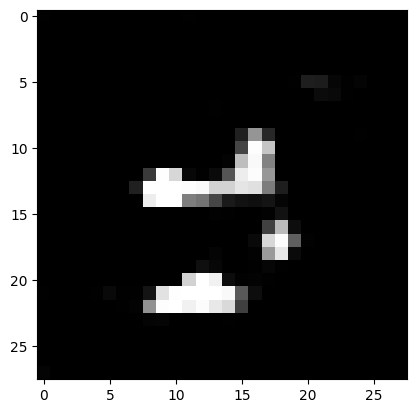

In [8]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [9]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
val = disc(sample)
print (val)

tf.Tensor([[-0.44624877]], shape=(1, 1), dtype=float32)


Now, we transfer the weights of discriminator to a new model, with the only difference being that the new model's last dense layer has 10 parameters instead of 1.

In [11]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(10, activation='softmax'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [12]:
# view the initialized weights and bias of the last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-1].weights

[<tf.Variable 'dense_2/kernel:0' shape=(6272, 10) dtype=float32, numpy=
 array([[ 1.0706980e-02,  2.6355721e-02, -1.7586740e-02, ...,
          1.4122810e-02,  3.0531634e-02, -1.7356267e-02],
        [ 2.6895925e-02, -2.4469569e-05,  5.5081435e-03, ...,
         -2.2136830e-02, -6.0187001e-03, -1.4732566e-02],
        [-1.8660624e-02, -1.4278214e-02,  5.6673214e-03, ...,
         -2.5704106e-02,  6.1044656e-03,  4.0100887e-03],
        ...,
        [ 1.2546327e-02,  2.5962606e-02, -2.2965850e-02, ...,
          2.1774501e-02, -7.3919352e-03, -5.9668943e-03],
        [-1.3888454e-02,  1.2060728e-02,  2.0154264e-02, ...,
          2.0434879e-02, -2.9005358e-02,  2.0367276e-02],
        [ 2.5390223e-02,  1.5130937e-03, -2.9525295e-02, ...,
         -3.5708807e-03, -1.6869828e-02, -1.7390035e-02]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [13]:
(train_img, train_lb), (test_img, test_lb) = tf.keras.datasets.mnist.load_data()

print(train_img.shape, train_lb.shape, test_img.shape, test_lb.shape, '\n')

# set random seed
np.random.seed(42)
trainsize = 10000  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 10000  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,) 

(10000, 28, 28) (10000,) (10000, 28, 28) (10000,)


In [14]:
X_train[-2000:].shape

(2000, 28, 28)

In [15]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=5,
                        validation_data=(test_images, test_labels))


Epoch 1/5


2024-11-25 13:19:47.174059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 99/100 [============================>.] - ETA: 0s - loss: 1.7127 - accuracy: 0.5632

2024-11-25 13:19:52.020269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 6s 32ms/step - loss: 1.7088 - accuracy: 0.5640 - val_loss: 1.2750 - val_accuracy: 0.7643
Epoch 2/5
100/100 [==============================] - 3s 29ms/step - loss: 1.1217 - accuracy: 0.7707 - val_loss: 0.9434 - val_accuracy: 0.8212
Epoch 3/5
100/100 [==============================] - 3s 28ms/step - loss: 0.8917 - accuracy: 0.8155 - val_loss: 0.7844 - val_accuracy: 0.8451
Epoch 4/5
100/100 [==============================] - 4s 41ms/step - loss: 0.7700 - accuracy: 0.8350 - val_loss: 0.6900 - val_accuracy: 0.8570
Epoch 5/5
100/100 [==============================] - 3s 27ms/step - loss: 0.6893 - accuracy: 0.8442 - val_loss: 0.6268 - val_accuracy: 0.8649


In [16]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

# optimizer=new_model.optimizer
# optimizer.learning_rate=0.005
    
new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=10,
                        validation_data=(test_images, test_labels)) 


Epoch 1/10


2024-11-25 13:20:05.728272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.8644

2024-11-25 13:20:17.282949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 13s 59ms/step - loss: 0.4902 - accuracy: 0.8644 - val_loss: 0.3922 - val_accuracy: 0.8885
Epoch 2/10
100/100 [==============================] - 6s 58ms/step - loss: 0.4023 - accuracy: 0.8815 - val_loss: 0.3451 - val_accuracy: 0.9020
Epoch 3/10
100/100 [==============================] - 6s 58ms/step - loss: 0.3580 - accuracy: 0.8933 - val_loss: 0.3160 - val_accuracy: 0.9111
Epoch 4/10
100/100 [==============================] - 7s 72ms/step - loss: 0.3285 - accuracy: 0.9032 - val_loss: 0.2951 - val_accuracy: 0.9150
Epoch 5/10
100/100 [==============================] - 6s 58ms/step - loss: 0.3075 - accuracy: 0.9090 - val_loss: 0.2784 - val_accuracy: 0.9212
Epoch 6/10
100/100 [==============================] - 6s 55ms/step - loss: 0.2874 - accuracy: 0.9159 - val_loss: 0.2637 - val_accuracy: 0.9252
Epoch 7/10
100/100 [==============================] - 6s 59ms/step - loss: 0.2722 - accuracy: 0.9189 - val_loss: 0.2521 - val_accuracy: 0.9286
Epoch 8/1

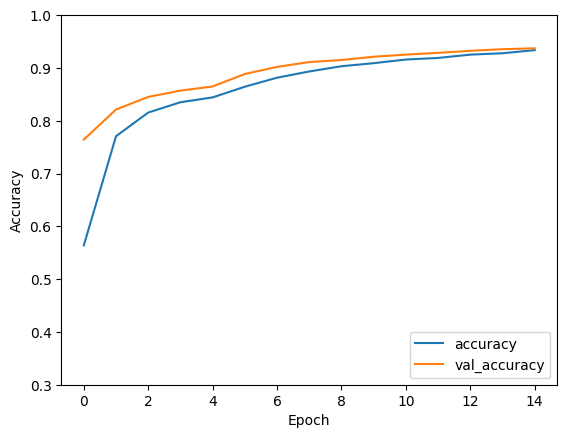

In [17]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, training accuracy and testing are around 0.91 and 0.92 after 15 epochs.

2024-11-25 13:21:15.102624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step
[[6.47699835e-07 1.60883821e-04 9.85767663e-01 1.28977457e-02
  1.41124525e-08 2.97946201e-07 2.30032983e-05 1.58067530e-06
  1.14532281e-03 2.75278353e-06]]
prediction: 2


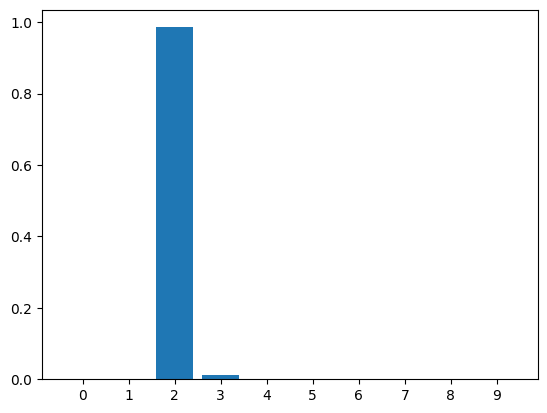

In [18]:
# demonstration: predict the ith test digit
i = 15
prediction = new_model.predict(test_images[i].reshape(1,28,28,1))
# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

actual label: 2


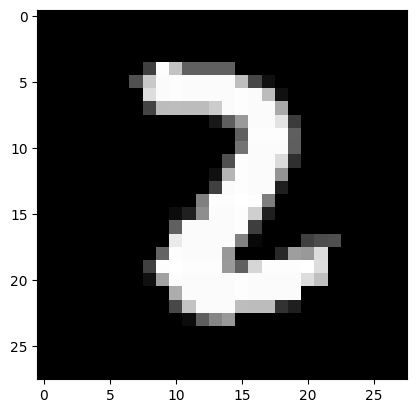

In [19]:
# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

In [20]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

313/313 [==============================] - 8s 15ms/step


2024-11-25 13:21:27.746524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:21:27.746589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-25 13:21:27.846312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:21:27.846391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory) -> physical PluggableDevice (device: 0, name: 

In [21]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

2024-11-25 13:21:28.028904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 13:21:28.028999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


array([[ 965,    0,    1,    0,    1,    3,    7,    1,    2,    0],
       [   0, 1107,    3,    2,    0,    0,    5,    2,   16,    0],
       [  12,    3,  932,   16,   10,    1,    8,   18,   26,    6],
       [   2,    0,   10,  943,    0,   23,    1,    9,   12,   10],
       [   1,    1,    3,    1,  921,    0,   13,    1,    9,   32],
       [   6,    3,    2,   22,    1,  820,   10,    1,   20,    7],
       [  13,    3,    3,    1,    9,    6,  919,    0,    4,    0],
       [   4,    6,   21,    5,    5,    1,    0,  944,    5,   37],
       [   8,    4,    5,   11,    7,   12,    8,   10,  894,   15],
       [   9,    5,    3,    9,   23,    8,    0,   12,   14,  926]],
      dtype=int32)

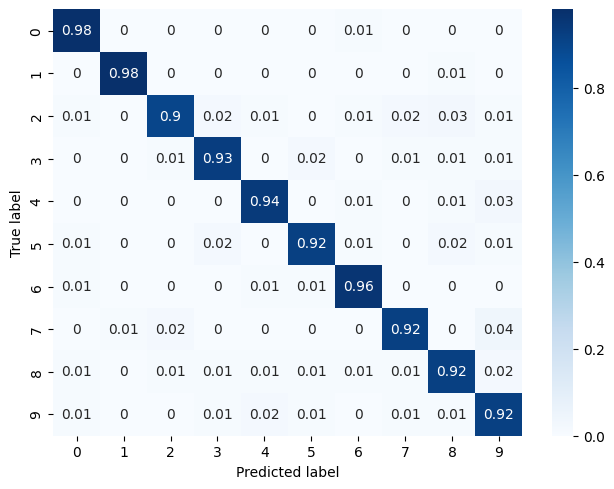

In [22]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)

figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()